
STEAM REVIEWS - DATA PREPROCESSING & EDA PIPELINE
LOADING DATA FROM SQLITE DATABASE

Available tables: ['players', 'games', 'reviews']

Columns in 'reviews' table:
                   name     type
0                 appid  INTEGER
1             author_id  INTEGER
2                review     TEXT
3           review_date     TEXT
4       playtime_review  INTEGER
5      playtime_forever  INTEGER
6              voted_up  INTEGER
7           votes_funny  INTEGER
8              votes_up  INTEGER
9         received_free  INTEGER
10  weighted_vote_score  NUMERIC
11       steam_purchase  INTEGER
12        comment_count  INTEGER
13     recommendationid  INTEGER

✓ Successfully loaded 98,755 records from 'reviews' table

DATA OVERVIEW

Dataset Shape: 98,755 rows × 14 columns

Memory Usage: 61.20 MB

--------------------------------------------------------------------------------
COLUMN TYPES
--------------------------------------------------------------------------------
appid                    

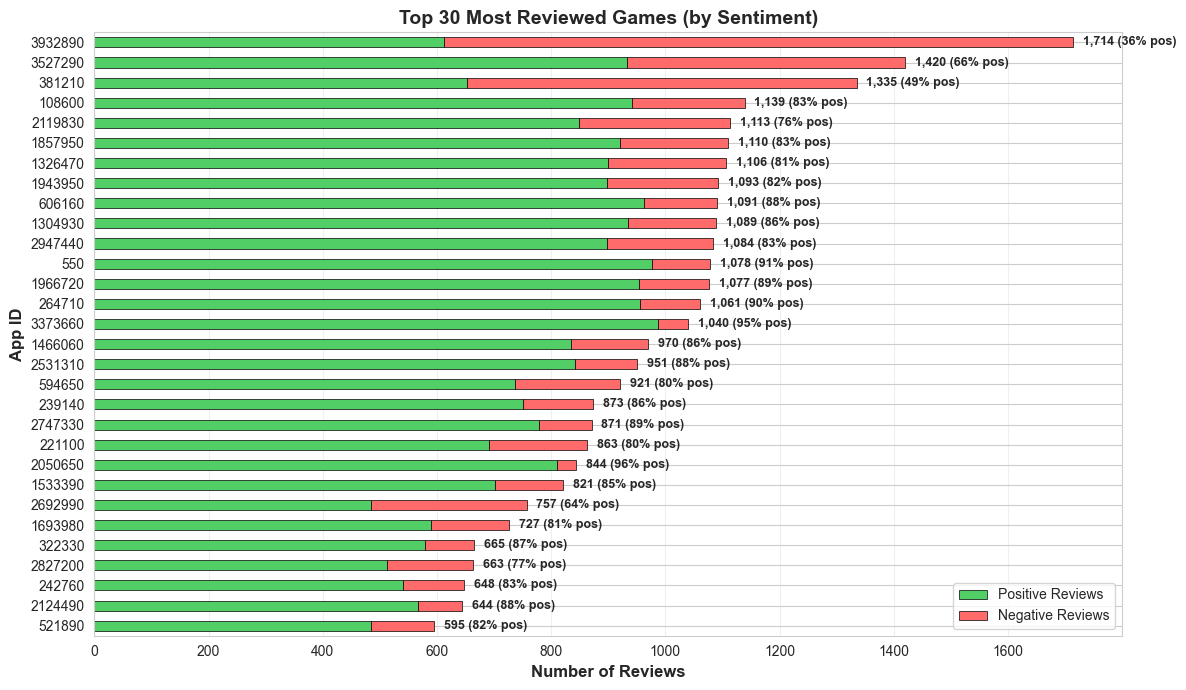


TOP 10 MOST REVIEWED GAMES
 1. App 3932890:  1,714 reviews (35.7% positive)
 2. App 3527290:  1,420 reviews (65.6% positive)
 3. App 381210:  1,335 reviews (48.8% positive)
 4. App 108600:  1,139 reviews (82.6% positive)
 5. App 2119830:  1,113 reviews (76.3% positive)
 6. App 1857950:  1,110 reviews (83.0% positive)
 7. App 1326470:  1,106 reviews (81.4% positive)
 8. App 1943950:  1,093 reviews (82.2% positive)
 9. App 606160:  1,091 reviews (88.3% positive)
10. App 1304930:  1,089 reviews (85.9% positive)
11. App 2947440:  1,084 reviews (82.8% positive)
12. App 550:  1,078 reviews (90.6% positive)
13. App 1966720:  1,077 reviews (88.6% positive)
14. App 264710:  1,061 reviews (90.1% positive)
15. App 3373660:  1,040 reviews (95.0% positive)
16. App 1466060:    970 reviews (86.1% positive)
17. App 2531310:    951 reviews (88.4% positive)
18. App 594650:    921 reviews (80.0% positive)
19. App 239140:    873 reviews (86.0% positive)
20. App 2747330:    871 reviews (89.4% positive)
21

In [29]:
"""
Data Preprocessing and Exploratory Data Analysis (EDA)
For Steam Reviews Dataset

This script performs:
1. Data loading and validation
2. Data quality checks
3. Exploratory data analysis
4. Data cleaning and preprocessing
5. Feature engineering
6. Dataset balancing
7. Train/validation/test split
"""

import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pathlib

warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Download NLTK data if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')


# ============================================================================
# 1. DATA LOADING
# ============================================================================

def load_data_from_sqlite(db_path, table_name="reviews"):
    """Load data from SQLite database"""
    print("=" * 80)
    print("LOADING DATA FROM SQLITE DATABASE")
    print("=" * 80)

    try:
        conn = sqlite3.connect(db_path)

        # First, check what tables exist
        tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
        tables = pd.read_sql_query(tables_query, conn)
        print(f"\nAvailable tables: {tables['name'].tolist()}")

        # Get column names
        columns_query = f"PRAGMA table_info({table_name});"
        columns_info = pd.read_sql_query(columns_query, conn)
        print(f"\nColumns in '{table_name}' table:")
        print(columns_info[['name', 'type']])

        # Load data
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, conn)
        conn.close()

        print(f"\n✓ Successfully loaded {len(df):,} records from '{table_name}' table")

        return df

    except Exception as e:
        print(f"\n✗ Error loading data: {e}")
        return None


# ============================================================================
# 2. DATA OVERVIEW
# ============================================================================

def get_data_overview(df):
    """Get comprehensive overview of the dataset"""
    print("\n" + "=" * 80)
    print("DATA OVERVIEW")
    print("=" * 80)

    # Basic info
    print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB")

    # Column types
    print("\n" + "-" * 80)
    print("COLUMN TYPES")
    print("-" * 80)
    print(df.dtypes)

    # First few rows
    print("\n" + "-" * 80)
    print("SAMPLE DATA (First 5 rows)")
    print("-" * 80)
    print(df.head())

    # Statistical summary
    print("\n" + "-" * 80)
    print("STATISTICAL SUMMARY")
    print("-" * 80)
    print(df.describe(include='all'))

    return df


# ============================================================================
# 3. DATA QUALITY CHECKS
# ============================================================================

def check_data_quality(df):
    """Perform comprehensive data quality checks"""
    print("\n" + "=" * 80)
    print("DATA QUALITY CHECKS")
    print("=" * 80)

    quality_report = {}

    # 1. Missing values
    print("\n" + "-" * 80)
    print("MISSING VALUES")
    print("-" * 80)

    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Percentage': missing_pct
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

    if len(missing_df) > 0:
        print(missing_df)
        quality_report['missing_values'] = missing_df.to_dict()
    else:
        print("✓ No missing values found!")
        quality_report['missing_values'] = {}

    # 2. Duplicate records
    print("\n" + "-" * 80)
    print("DUPLICATE RECORDS")
    print("-" * 80)

    duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates:,} ({duplicates / len(df) * 100:.2f}%)")
    quality_report['duplicates'] = duplicates

    # 3. Check for empty strings
    print("\n" + "-" * 80)
    print("EMPTY STRING CHECK")
    print("-" * 80)

    text_columns = df.select_dtypes(include=['object']).columns
    for col in text_columns:
        empty_count = (df[col] == '').sum()
        if empty_count > 0:
            print(f"  {col}: {empty_count:,} empty strings ({empty_count / len(df) * 100:.2f}%)")
            quality_report[f'empty_{col}'] = empty_count

    # 4. Text length statistics (for review text)
    if 'review' in df.columns:
        print("\n" + "-" * 80)
        print("REVIEW TEXT LENGTH STATISTICS")
        print("-" * 80)

        df['text_length'] = df['review'].astype(str).apply(len)
        df['word_count'] = df['review'].astype(str).apply(lambda x: len(x.split()))

        print(f"  Min length: {df['text_length'].min()} characters")
        print(f"  Max length: {df['text_length'].max()} characters")
        print(f"  Mean length: {df['text_length'].mean():.2f} characters")
        print(f"  Median length: {df['text_length'].median():.2f} characters")
        print(f"  Mean word count: {df['word_count'].mean():.2f} words")

        # Very short reviews (potential issues)
        very_short = (df['text_length'] < 10).sum()
        print(f"\n  Reviews < 10 characters: {very_short:,} ({very_short / len(df) * 100:.2f}%)")

        # Very long reviews (potential issues)
        very_long = (df['text_length'] > 5000).sum()
        print(f"  Reviews > 5000 characters: {very_long:,} ({very_long / len(df) * 100:.2f}%)")

        quality_report['text_stats'] = {
            'min_length': int(df['text_length'].min()),
            'max_length': int(df['text_length'].max()),
            'mean_length': float(df['text_length'].mean()),
            'very_short': int(very_short),
            'very_long': int(very_long)
        }

    return quality_report, df


# ============================================================================
# 4. EXPLORATORY DATA ANALYSIS
# ============================================================================

def analyze_sentiment_distribution(df):
    """Analyze sentiment label distribution"""
    print("\n" + "=" * 80)
    print("SENTIMENT DISTRIBUTION ANALYSIS")
    print("=" * 80)

    labels = {1: 'Positive', 0: 'Negative'}

    # Identify sentiment column
    sentiment_col = 'voted_up'
    labeled_col = 'label'

    df[labeled_col] = df[sentiment_col].map(labels)

    # Get value counts
    sentiment_counts = df[labeled_col].value_counts()
    sentiment_pct = df[labeled_col].value_counts(normalize=True) * 100

    print("\n" + "-" * 80)
    print("SENTIMENT COUNTS")
    print("-" * 80)
    for label, count in sentiment_counts.items():
        pct = sentiment_pct[label]
        print(f"  {label}: {count:,} ({pct:.2f}%)")

    # Check for imbalance
    print("\n" + "-" * 80)
    print("CLASS BALANCE CHECK")
    print("-" * 80)

    max_count = sentiment_counts.max()
    min_count = sentiment_counts.min()
    imbalance_ratio = max_count / min_count

    print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

    if imbalance_ratio > 1.5:
        print(f"  ⚠ Dataset is imbalanced! Consider using:")
        print(f"    - Class weights")
        print(f"    - Oversampling minority class")
        print(f"    - Undersampling majority class")
    else:
        print(f"  ✓ Dataset is relatively balanced")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar plot
    sentiment_counts.plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#51cf66'])
    axes[0].set_title('Sentiment Distribution (Counts)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Sentiment', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)

    # Add count labels on bars
    for i, v in enumerate(sentiment_counts.values):
        axes[0].text(i, v + max_count * 0.01, f'{v:,}', ha='center', fontweight='bold')

    # Pie chart
    colors = ['#ff6b6b', '#51cf66'] if len(sentiment_counts) == 2 else None
    axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
                startangle=90, colors=colors)
    axes[1].set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(pathlib.Path(os.getcwd()).parent / 'results' / 'EDA' /  'sentiment_distribution.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved visualization: sentiment_distribution.png")
    plt.close()

    return sentiment_counts


def get_top_stored_reviews(df):
    print("\n" + "-" * 80)
    print("Top stored reviews")
    print("-" * 80)

    df_pivot = pd.crosstab(df['appid'], df['voted_up'])
    df_pivot.columns = ['negative', 'positive']  # Rename columns (0=negative, 1=positive)
    df_pivot['total'] = df_pivot['positive'] + df_pivot['negative']

    # Sort and get top 30
    df_top = df_pivot.sort_values('total', ascending=False).head(30)

    # Plot
    ax = df_top[['positive', 'negative']].plot(
        kind='barh', 
        stacked=True,
        figsize=(12, 7),
        color=['#51cf66', '#ff6b6b'],
        edgecolor='black',
        linewidth=0.5
    )

    plt.xlabel('Number of Reviews', fontweight='bold', fontsize=12)
    plt.ylabel('App ID', fontweight='bold', fontsize=12)
    plt.title('Top 30 Most Reviewed Games (by Sentiment)', fontweight='bold', fontsize=14)
    plt.legend(['Positive Reviews', 'Negative Reviews'], loc='lower right')
    plt.gca().invert_yaxis()

    # Add labels
    for i, (idx, row) in enumerate(df_top.iterrows()):
        total = row['total']
        positive_pct = (row['positive'] / total) * 100
        plt.text(total + df_top['total'].max()*0.01, i, 
                f"{total:,} ({positive_pct:.0f}% pos)", 
                va='center', fontweight='bold', fontsize=9)

    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(pathlib.Path(os.getcwd()).parent / 'results' / 'EDA' /  'top_30_games_sentiment.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary
    print("\n" + "="*80)
    print("TOP 10 MOST REVIEWED GAMES")
    print("="*80)
    for i, (appid, row) in enumerate(df_top.iterrows(), 1):
        pct = (row['positive'] / row['total']) * 100
        print(f"{i:2d}. App {appid}: {row['total']:>6,} reviews ({pct:.1f}% positive)")
    print("="*80)


def analyze_ratings(df):
    """Analyze rating distribution"""
    print("\n" + "=" * 80)
    print("RATING DISTRIBUTION ANALYSIS")
    print("=" * 80)

    if 'rating' not in df.columns:
        print("⚠ Warning: No rating column found!")
        return None

    # Rating statistics
    print("\n" + "-" * 80)
    print("RATING STATISTICS")
    print("-" * 80)
    print(f"  Mean rating: {df['rating'].mean():.2f}")
    print(f"  Median rating: {df['rating'].median():.2f}")
    print(f"  Std deviation: {df['rating'].std():.2f}")
    print(f"  Min rating: {df['rating'].min():.2f}")
    print(f"  Max rating: {df['rating'].max():.2f}")

    # Rating distribution
    rating_counts = df['rating'].value_counts().sort_index()

    print("\n" + "-" * 80)
    print("RATING DISTRIBUTION")
    print("-" * 80)
    for rating, count in rating_counts.items():
        pct = (count / len(df)) * 100
        bar = '█' * int(pct / 2)
        print(f"  {rating} stars: {count:6,} ({pct:5.2f}%) {bar}")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar plot
    rating_counts.plot(kind='bar', ax=axes[0], color='coral')
    axes[0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Rating (Stars)', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].tick_params(axis='x', rotation=0)

    # Add count labels
    for i, v in enumerate(rating_counts.values):
        axes[0].text(i, v + max(rating_counts.values) * 0.01, f'{v:,}', ha='center')

    # Box plot
    axes[1].boxplot(df['rating'].dropna(), vert=True)
    axes[1].set_title('Rating Distribution (Box Plot)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Rating (Stars)', fontsize=12)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(pathlib.Path(os.getcwd()).parent / 'results' / 'EDA' /  'rating_distribution.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved visualization: rating_distribution.png")
    plt.close()

    return rating_counts


def analyze_text_characteristics(df):
    """Analyze text characteristics"""
    print("\n" + "=" * 80)
    print("TEXT CHARACTERISTICS ANALYSIS")
    print("=" * 80)

    if 'review' not in df.columns:
        print("⚠ Warning: No review column found!")
        return None

    # Ensure text_length and word_count exist
    if 'text_length' not in df.columns:
        df['text_length'] = df['review'].astype(str).apply(len)
    if 'word_count' not in df.columns:
        df['word_count'] = df['review'].astype(str).apply(lambda x: len(x.split()))

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Text length distribution
    axes[0, 0].hist(df['text_length'], bins=50, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Review Length Distribution (Characters)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Characters')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(df['text_length'].mean(), color='red', linestyle='--',
                       label=f'Mean: {df["text_length"].mean():.0f}')
    axes[0, 0].legend()

    # 2. Word count distribution
    axes[0, 1].hist(df['word_count'], bins=50, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Words')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(df['word_count'].mean(), color='red', linestyle='--',
                       label=f'Mean: {df["word_count"].mean():.0f}')
    axes[0, 1].legend()

    # 3. Box plot - Text length by sentiment
    sentiment_col = 'voted_up'

    if sentiment_col:
        df.boxplot(column='text_length', by=sentiment_col, ax=axes[1, 0])
        axes[1, 0].set_title('Text Length by Sentiment', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Sentiment')
        axes[1, 0].set_ylabel('Text Length (Characters)')
        plt.sca(axes[1, 0])
        plt.xticks(rotation=0)

    # 4. Box plot - Word count by sentiment
    if sentiment_col:
        df.boxplot(column='word_count', by=sentiment_col, ax=axes[1, 1])
        axes[1, 1].set_title('Word Count by Sentiment', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Sentiment')
        axes[1, 1].set_ylabel('Word Count')
        plt.sca(axes[1, 1])
        plt.xticks(rotation=0)

    plt.tight_layout()
    plt.savefig(pathlib.Path(os.getcwd()).parent / 'results' / 'EDA' /  'text_characteristics.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved visualization: text_characteristics.png")
    plt.close()


def generate_wordclouds(df):
    """Generate word clouds for positive and negative reviews"""
    print("\n" + "=" * 80)
    print("GENERATING WORD CLOUDS")
    print("=" * 80)

    sentiment_col = 'voted_up'

    # Get stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update(['product', 'review', 'steam', 'bought', 'buy', 'purchased'])

    # Get unique sentiment values
    sentiments = df[sentiment_col].unique()

    fig, axes = plt.subplots(1, len(sentiments), figsize=(14, 6))
    if len(sentiments) == 1:
        axes = [axes]

    for idx, sentiment in enumerate(sentiments):
        # Filter reviews
        reviews = df[df[sentiment_col] == sentiment]['review'].astype(str)
        text = ' '.join(reviews.values)

        # Generate word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            stopwords=stop_words,
            max_words=100,
            colormap='viridis' if sentiment in [1, 'positive'] else 'Reds'
        ).generate(text)

        # Plot
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'Word Cloud - {sentiment}', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(pathlib.Path(os.getcwd()).parent / 'results' / 'EDA' /  'wordclouds.png', dpi=300, bbox_inches='tight')
    print("✓ Saved visualization: wordclouds.png")
    plt.close()


# ============================================================================
# 5. DATA CLEANING
# ============================================================================

def clean_data(df):
    """Clean and preprocess the data"""
    print("\n" + "=" * 80)
    print("DATA CLEANING")
    print("=" * 80)

    initial_count = len(df)
    print(f"\nInitial record count: {initial_count:,}")

    # 1. Remove duplicates
    df = df.drop_duplicates()
    after_dupes = len(df)
    print(f"After removing duplicates: {after_dupes:,} ({initial_count - after_dupes:,} removed)")

    # 2. Remove rows with missing review text
    if 'review' in df.columns:
        df = df[df['review'].notna()]
        df = df[df['review'].astype(str).str.strip() != '']
        after_text = len(df)
        print(f"After removing missing text: {after_text:,} ({after_dupes - after_text:,} removed)")

    # 3. Remove very short reviews (likely not useful)
    if 'review' in df.columns:
        df['text_length'] = df['review'].astype(str).apply(len)
        df = df[df['text_length'] >= 10]
        after_short = len(df)
        print(f"After removing very short reviews: {after_short:,} ({after_text - after_short:,} removed)")

    # 4. Remove rows with missing sentiment labels
    sentiment_col = 'voted_up'
    
    if sentiment_col:
        df = df[df[sentiment_col].notna()]
        after_sentiment = len(df)
        print(f"After removing missing sentiments: {after_sentiment:,} ({after_short - after_sentiment:,} removed)")

    # 5. Standardize sentiment labels to 0 and 1
    if sentiment_col:
        unique_values = df[sentiment_col].unique()
        print(f"\nUnique sentiment values: {unique_values}")

        # Convert to binary if needed
        if df[sentiment_col].dtype == object:
            # Map common sentiment labels
            sentiment_map = {
                'positive': 1, 'pos': 1, 'good': 1, '1': 1, 1: 1,
                'negative': 0, 'neg': 0, 'bad': 0, '0': 0, 0: 0
            }
            df[sentiment_col] = df[sentiment_col].map(sentiment_map)
            print(f"Converted sentiment labels to binary (0/1)")

    # 6. Clean text (basic cleaning)
    if 'review' in df.columns:
        print("\nCleaning review text...")
        df['review_text_clean'] = df['review'].apply(clean_text)

    print(f"\nFinal record count: {len(df):,}")
    print(
        f"Total records removed: {initial_count - len(df):,} ({(initial_count - len(df)) / initial_count * 100:.2f}%)")

    return df


def clean_text(text):
    """Clean review text"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove [] type tags
    text = re.sub(r'\[.*?\]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove leading/trailing whitespace
    text = text.strip()

    return text


# ============================================================================
# 6. DATA BALANCING
# ============================================================================

def balance_dataset(df, method='undersample'):
    """Balance the dataset by sentiment"""
    print("\n" + "=" * 80)
    print(f"DATASET BALANCING (Method: {method.upper()})")
    print("=" * 80)

    sentiment_col = 'voted_up'

    # Get counts
    sentiment_counts = df[sentiment_col].value_counts()
    print(f"\nBefore balancing:")
    for label, count in sentiment_counts.items():
        print(f"  {label}: {count:,}")

    if method == 'undersample':
        # Undersample majority class
        min_count = sentiment_counts.min()

        balanced_dfs = []
        for label in sentiment_counts.index:
            label_df = df[df[sentiment_col] == label]
            sampled_df = label_df.sample(n=min_count, random_state=42)
            balanced_dfs.append(sampled_df)

        df_balanced = pd.concat(balanced_dfs, ignore_index=True)

    elif method == 'oversample':
        # Oversample minority class
        max_count = sentiment_counts.max()

        balanced_dfs = []
        for label in sentiment_counts.index:
            label_df = df[df[sentiment_col] == label]
            sampled_df = label_df.sample(n=max_count, replace=True, random_state=42)
            balanced_dfs.append(sampled_df)

        df_balanced = pd.concat(balanced_dfs, ignore_index=True)

    else:
        print("Invalid method! Using original dataset.")
        return df

    # Shuffle
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    # Show new distribution
    new_counts = df_balanced[sentiment_col].value_counts()
    print(f"\nAfter balancing:")
    for label, count in new_counts.items():
        print(f"  {label}: {count:,}")

    return df_balanced


# ============================================================================
# 7. TRAIN/VAL/TEST SPLIT
# ============================================================================

def split_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
    """Split data into train, validation, and test sets"""
    print("\n" + "=" * 80)
    print("DATA SPLITTING")
    print("=" * 80)

    from sklearn.model_selection import train_test_split

    sentiment_col = 'voted_up'

    # First split: train + temp
    train_df, temp_df = train_test_split(
        df,
        train_size=train_size,
        stratify=df[sentiment_col],
        random_state=42
    )

    # Second split: val + test
    val_relative = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=val_relative,
        stratify=temp_df[sentiment_col],
        random_state=42
    )

    print(f"\nDataset split:")
    print(f"  Training:   {len(train_df):6,} ({len(train_df) / len(df) * 100:.1f}%)")
    print(f"  Validation: {len(val_df):6,} ({len(val_df) / len(df) * 100:.1f}%)")
    print(f"  Test:       {len(test_df):6,} ({len(test_df) / len(df) * 100:.1f}%)")
    print(f"  Total:      {len(df):6,}")

    # Check distribution in each set
    print(f"\nSentiment distribution:")
    print(f"  Training:   {train_df[sentiment_col].value_counts().to_dict()}")
    print(f"  Validation: {val_df[sentiment_col].value_counts().to_dict()}")
    print(f"  Test:       {test_df[sentiment_col].value_counts().to_dict()}")

    return train_df, val_df, test_df


# ============================================================================
# 8. SAVE PROCESSED DATA
# ============================================================================

def save_processed_data(train_df, val_df, test_df):
    """Save processed datasets"""
    print("\n" + "=" * 80)
    print("SAVING PROCESSED DATA")
    print("=" * 80)
    
    output_dir= pathlib.Path(os.getcwd()).parent / 'results/EDA/processed_data'
    os.makedirs(output_dir, exist_ok=True)

    # Save to CSV
    train_path = os.path.join(output_dir, 'train.csv')
    val_path = os.path.join(output_dir, 'val.csv')
    test_path = os.path.join(output_dir, 'test.csv')

    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    test_df.to_csv(test_path, index=False)

    print(f"\n✓ Saved training data:   {train_path}")
    print(f"✓ Saved validation data: {val_path}")
    print(f"✓ Saved test data:       {test_path}")

    # Also save to SQLite
    db_path = os.path.join(output_dir, 'reviews_processed.db')
    conn = sqlite3.connect(db_path)

    train_df.to_sql('train', conn, if_exists='replace', index=False)
    val_df.to_sql('validation', conn, if_exists='replace', index=False)
    test_df.to_sql('test', conn, if_exists='replace', index=False)

    conn.close()

    print(f"✓ Saved SQLite database: {db_path}")

    return str(output_dir)


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def run_preprocessing_pipeline(db_path, table_name='reviews', balance_method='undersample'):
    """Run complete preprocessing and EDA pipeline"""

    print("\n" + "=" * 80)
    print("STEAM REVIEWS - DATA PREPROCESSING & EDA PIPELINE")
    print("=" * 80)

    # 1. Load data
    df = load_data_from_sqlite(db_path, table_name)
    if df is None:
        return

    # 2. Data overview
    df = get_data_overview(df)

    # 3. Data quality checks
    quality_report, df = check_data_quality(df)

    # 4. EDA
    print("\n" + "=" * 80)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 80)

    analyze_sentiment_distribution(df)
    get_top_stored_reviews(df)
    analyze_text_characteristics(df)
    generate_wordclouds(df)

    # 5. Data cleaning
    df_clean = clean_data(df)

    # 6. Balance dataset
    df_balanced = balance_dataset(df_clean, method=balance_method)

    # 7. Split data
    train_df, val_df, test_df = split_data(df_balanced)

    # 8. Save processed data
    output_dir = save_processed_data(train_df, val_df, test_df)

    # 9. Generate summary report
    generate_summary_report(df, df_clean, df_balanced, train_df, val_df, test_df)

    print("\n" + "=" * 80)
    print("PREPROCESSING PIPELINE COMPLETED!")
    print("=" * 80)
    print(f"\n✓ Processed data saved to: {output_dir}/")
    print(f"✓ Visualizations saved as PNG files in current directory")
    print(f"✓ Summary report saved as: preprocessing_summary.txt")

    # return df_balanced, train_df, val_df, test_df


def generate_summary_report(df_original, df_clean, df_balanced, train_df, val_df, test_df):
    """Generate a summary report"""

    report = []
    report.append("=" * 80)
    report.append("DATA PREPROCESSING SUMMARY REPORT")
    report.append("=" * 80)
    report.append("")

    # Original data
    report.append("ORIGINAL DATASET")
    report.append("-" * 80)
    report.append(f"Total records: {len(df_original):,}")
    report.append(f"Columns: {', '.join(df_original.columns.tolist())}")
    report.append("")

    # After cleaning
    report.append("AFTER CLEANING")
    report.append("-" * 80)
    report.append(f"Total records: {len(df_clean):,}")
    report.append(
        f"Records removed: {len(df_original) - len(df_clean):,} ({(len(df_original) - len(df_clean)) / len(df_original) * 100:.2f}%)")
    report.append("")

    # After balancing
    report.append("AFTER BALANCING")
    report.append("-" * 80)
    report.append(f"Total records: {len(df_balanced):,}")

    sentiment_col = 'voted_up'
    if sentiment_col:
        sentiment_dist = df_balanced[sentiment_col].value_counts()
        report.append(f"Sentiment distribution:")
        for label, count in sentiment_dist.items():
            report.append(f"  {label}: {count:,}")
    report.append("")

    # Final splits
    report.append("FINAL DATA SPLITS")
    report.append("-" * 80)
    report.append(f"Training set:   {len(train_df):,} ({len(train_df) / len(df_balanced) * 100:.1f}%)")
    report.append(f"Validation set: {len(val_df):,} ({len(val_df) / len(df_balanced) * 100:.1f}%)")
    report.append(f"Test set:       {len(test_df):,} ({len(test_df) / len(df_balanced) * 100:.1f}%)")
    report.append(f"Total:          {len(df_balanced):,}")
    report.append("")

    # Files generated
    report.append("FILES GENERATED")
    report.append("-" * 80)
    report.append("Visualizations:")
    report.append("  - sentiment_distribution.png")
    report.append("  - text_characteristics.png")
    report.append("  - wordclouds.png")
    report.append("  - sentiment_by_category.png")
    report.append("")
    report.append("Processed data:")
    report.append("  - processed_data/train.csv")
    report.append("  - processed_data/val.csv")
    report.append("  - processed_data/test.csv")
    report.append("  - processed_data/reviews_processed.db")
    report.append("")

    report.append("=" * 80)

    # Save report
    report_text = "\n".join(report)
    with open(pathlib.Path(os.getcwd()).parent / 'results' / 'EDA' / 'preprocessing_summary.txt', 'w') as f:
        f.write(report_text)

    # Also print to console
    print("\n" + report_text)


# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    # Configuration
    DB_PATH = r"E:\SynologyDrive\ironhack\week_14\day_2\nlp-business-case-automated-customers-reviews\data\raw\gamesDB.db"  # Update with your database path
    TABLE_NAME = "reviews"  # Update with your table name
    BALANCE_METHOD = "undersample"  # Options: 'undersample', 'oversample', or None

    # Run pipeline
    run_preprocessing_pipeline(
        db_path=DB_PATH,
        table_name=TABLE_NAME,
        balance_method=BALANCE_METHOD
    )